In [1]:
import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import geopy.distance
from tqdm import tqdm
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

### Raw Data Collection

In [2]:
df = pd.read_csv('/Users/v/Desktop/Uber/uber.csv')

df.drop(['Unnamed: 0','key'], axis=1, inplace=True)
display(df.head())

target = 'fare_amount'
features = [i for i in df.columns if i not in [target]]

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5



Inference: The Datset consists of 7 features & 200000 samples.


In [3]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)
df.dropna(inplace=True)

                   Total Null Values  Percentage
fare_amount                        0         0.0
pickup_datetime                    0         0.0
pickup_longitude                   0         0.0
pickup_latitude                    0         0.0
passenger_count                    0         0.0
dropoff_longitude                  1         0.0
dropoff_latitude                   1         0.0


In [4]:
# Reframing the columns

df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

df.pickup_datetime=pd.to_datetime(df.pickup_datetime)

df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                      8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})
df['Hourly_Segments'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',8:'H3',
                                     9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',15:'H4',16:'H5',
                                     17:'H5',18:'H5',19:'H5',20:'H6',21:'H6',22:'H6',23:'H6'})

df['Distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).m,2) for i in df.index]

df.drop(['pickup_datetime','month', 'hour',], axis=1, inplace=True)

original_df = df.copy(deep=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,Q2,H5,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,Q3,H6,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,Q3,H6,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,Q2,H3,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,Q3,H5,4483.73


In [5]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199987 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199987 non-null  float64
 1   pickup_longitude   199987 non-null  float64
 2   pickup_latitude    199987 non-null  float64
 3   dropoff_longitude  199987 non-null  float64
 4   dropoff_latitude   199987 non-null  float64
 5   passenger_count    199987 non-null  int64  
 6   year               199987 non-null  int64  
 7   weekday            199987 non-null  int64  
 8   Monthly_Quarter    199987 non-null  object 
 9   Hourly_Segments    199987 non-null  object 
 10  Distance           199987 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 22.3+ MB


In [6]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

Monthly_Quarter           4
Hourly_Segments           6
year                      7
weekday                   7
passenger_count           8
fare_amount            1244
pickup_longitude      71055
dropoff_longitude     76890
pickup_latitude       83831
dropoff_latitude      90582
Distance             164542
dtype: int64

In [7]:
#Checking number of unique rows in each feature

nu = df.drop([target], axis=1).nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df.drop([target], axis=1).shape[1]):
    if nu.values[i]<=24:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 5 numerical & 5 categorical features.


In [8]:
#Checking the stats of all the columns

display(df.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Distance
count,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,1.999870e+05
mean,11.359849,-72.501786,39.917937,-72.511608,39.922031,1.684544,2011.742463,3.048383,2.056346e+04
std,9.901868,10.449955,6.130412,10.412192,6.117669,1.385999,1.856438,1.946960,3.796638e+05
min,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,2009.000000,0.000000,0.000000e+00
25%,6.000000,-73.992064,40.734793,-73.991407,40.733823,1.000000,2010.000000,1.000000,1.215530e+03
50%,8.500000,-73.981822,40.752592,-73.980092,40.753042,1.000000,2012.000000,3.000000,2.121280e+03
75%,12.500000,-73.967154,40.767157,-73.963658,40.768000,2.000000,2013.000000,5.000000,3.874255e+03
max,499.000000,40.808425,48.018760,40.831932,45.031598,208.000000,2015.000000,6.000000,8.783594e+06


### EDA

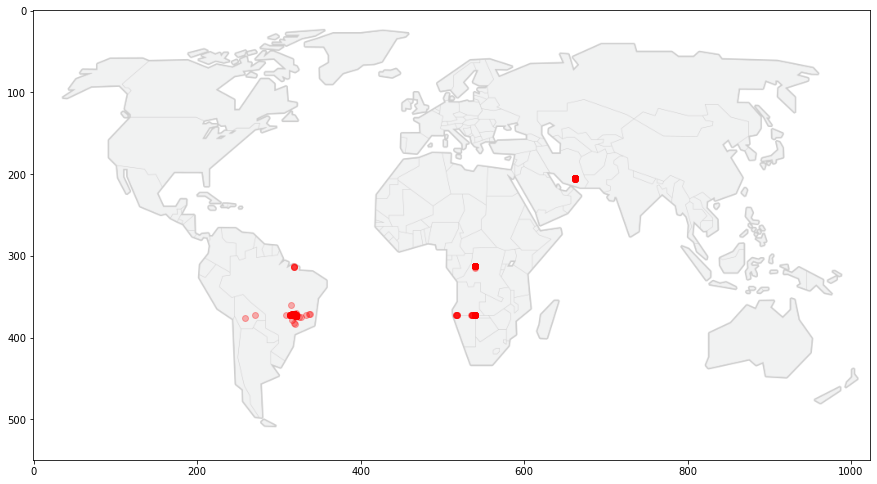

In [9]:
plt.figure(figsize=[15,10])
a=plt.imread('https://raw.githubusercontent.com/Masterx-AI/Project_Uber_Fare_Prediction/main/wm.png')
plt.imshow(a, alpha=0.2)
plt.scatter( (df.pickup_longitude+180)*3,(df.pickup_latitude+215)*1.45555555,alpha=0.3, color='red')
#mdf.plot(kind='scatter',x='pickup_latitude',y='pickup_longitude',alpha=0.1)
plt.show()

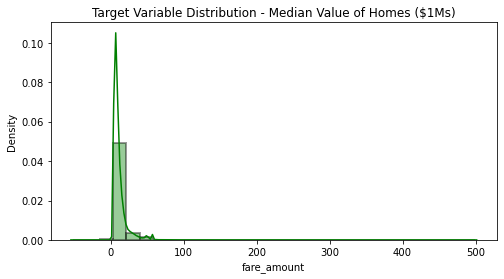

In [10]:
# Find the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

                               Visualising Categorical Features:                                


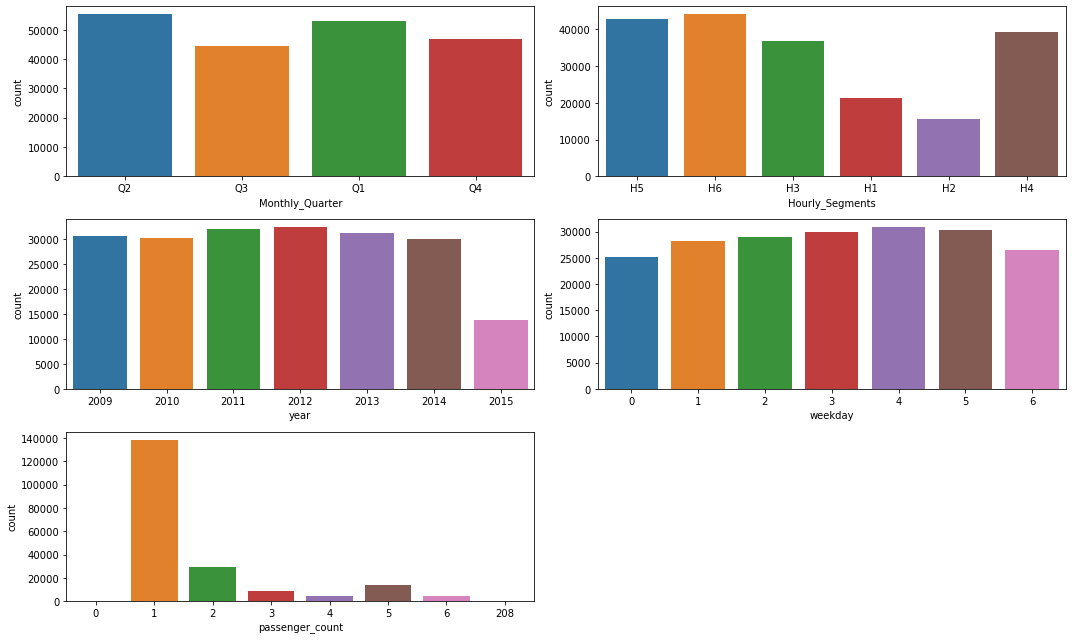

In [11]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

# for i in range(len(cf)):
#     if df[cf[i]].nunique()<=4:
#         plt.subplot(math.ceil(len(cf)/n),n,i+1)
#         sns.countplot(df[cf[i]])
#     else:
#         plt.subplot(math.ceil(len(cf)/2),2,i)
#         sns.countplot(df[cf[i]])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=12:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-3)
        sns.countplot(df[cf[i]])
        #plt.subplot(4,2,8)
        #sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

                                 Numeric Features Distribution                                  


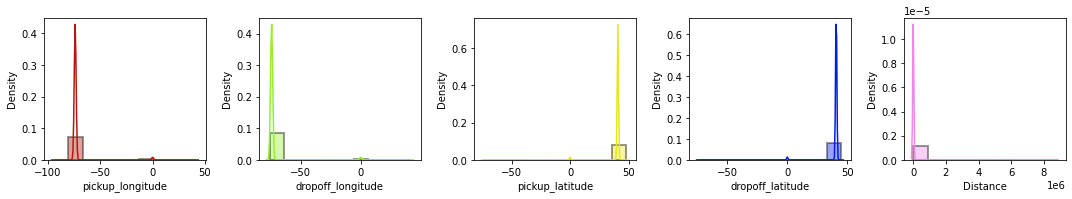

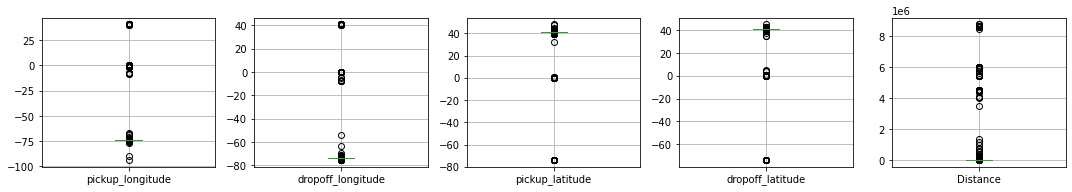

In [12]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(100))

n=5

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

### Preliminary Data Process

In [13]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)
df.drop(['pickup_latitude','pickup_longitude',
         'dropoff_latitude','dropoff_longitude'],axis=1)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 109


In [14]:
df.dropna(inplace=True)

In [15]:
#Converting categorical Columns to Numeric

df1 = df.copy()
df3 = df1.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape


Dummy Encoding on features:
Monthly_Quarter
Hourly_Segments
year
weekday
passenger_count


(199878, 33)

In [16]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1681.11,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2454.36,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
2,12.9,-74.005043,40.740770,-73.962565,40.772647,5039.60,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,1661.44,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,4.9,-73.969019,40.755910,-73.969019,40.755910,0.00,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0



Inference:
Before removal of outliers, The dataset had 199878 samples.
After removal of outliers, The dataset now has 163203 samples.


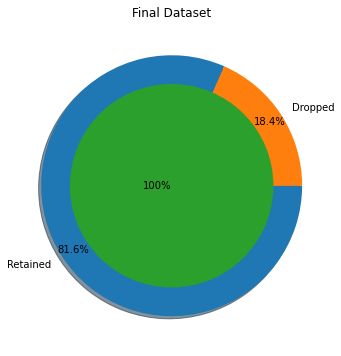


Inference: After the cleanup process, 36784 samples were dropped, while retaining 18.39% of the data.


In [17]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

### Data Manipulation

In [18]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (163203, 32) (163203,) 
Training set  --->  (130562, 32) (130562,) 
Testing set   --->  (32641, 32)  (32641,)


In [19]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,...,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05
mean,-6.304892e-13,-2.335703e-15,-1.255051e-13,1.803562e-14,-1.397349e-16,-5.364534e-15,1.615100e-15,-1.027500e-15,4.044123e-15,-2.618668e-15,...,-1.316621e-15,2.291492e-16,3.253467e-16,6.353702e-16,1.735940e-15,1.159121e-15,3.149257e-15,-2.750499e-15,-4.009598e-15,-1.562710e-15
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.961437e+00,-2.897556e+00,-2.919757e+00,-2.867446e+00,-1.622863e+00,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,-1.505327e+00,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
25%,-6.783829e-01,-6.847366e-01,-6.710313e-01,-6.636110e-01,-7.629052e-01,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,-1.505327e+00,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
50%,-6.341797e-02,3.271920e-02,-6.532058e-02,4.834418e-02,-2.347775e-01,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,6.643075e-01,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
75%,6.429738e-01,6.539807e-01,6.174684e-01,6.350862e-01,5.652279e-01,1.624673e+00,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,6.643075e-01,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
max,3.255964e+00,2.807711e+00,3.137233e+00,2.805374e+00,2.933357e+00,1.624673e+00,1.881034e+00,1.799003e+00,3.613456e+00,2.051975e+00,...,2.329905e+00,2.371387e+00,2.630507e+00,6.643075e-01,2.425547e+00,4.605646e+00,6.741425e+00,3.651694e+00,6.828835e+00,3.613323e+02



                                Standardardization on Testing set                                


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,...,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,3.264100e+04
mean,0.009496,0.003957,0.002645,0.010718,0.003829,-0.004419,0.008474,-0.004463,0.001664,0.002463,...,-0.001824,0.000336,-0.000882,-0.005507,0.003732,-0.006578,0.000262,0.001559,0.013835,-2.767536e-03
std,1.002215,1.000929,0.993715,1.001776,1.001768,0.997773,1.005681,0.997227,1.002787,1.001937,...,0.998279,1.000343,0.999022,1.002313,1.003758,0.985453,1.000877,1.002644,1.045127,1.405581e-15
min,-2.708732,-2.887521,-2.876670,-2.857408,-1.622863,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,-1.505327,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
25%,-0.674309,-0.688962,-0.664415,-0.652657,-0.762707,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,-1.505327,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
50%,-0.048188,0.048564,-0.060663,0.060627,-0.230528,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,0.664307,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
75%,0.653268,0.661489,0.621690,0.657956,0.574644,1.624673,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,0.664307,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
max,3.252830,2.800652,3.132185,2.804325,2.932838,1.624673,1.881034,1.799003,3.613456,2.051975,...,2.329905,2.371387,2.630507,0.664307,2.425547,4.605646,6.741425,3.651694,6.828835,-2.767536e-03


### Predictive Modelling

In [20]:
# First define a function to evaluate our models 

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>50].columns,3)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

<<<------------------------- Evaluating Multiple Linear Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 0.01204206  0.02299853  0.07469811 -0.37043056  2.79535285  0.06599939
  0.1320065   0.22069881 -0.06375863  0.31634899  0.40009521  0.29126121
  0.03587546  0.04297281  0.02824331  0.19545138  0.53625674  0.62035748
  0.48235245  0.08731832  0.12995267  0.15062433  0.12700495  0.01780948
 -0.05599052  0.09916235  0.13013649  0.08182256  0.06936402  0.0822533
  0.03376945  0.02150019]
The Intercept of the Regresion Model was found to be  8.55061694826981


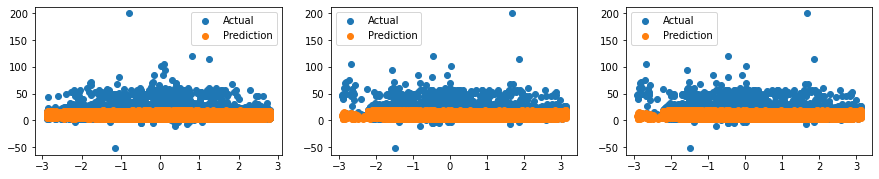



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.45722249501525936
Residual Sum of Squares (RSS) on Training set  ---> 1326512.5745127923
Mean Squared Error (MSE) on Training set       ---> 10.160020331434815
Root Mean Squared Error (RMSE) on Training set ---> 3.187478679369451

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.3294397974348473
Residual Sum of Squares (RSS) on Training set  ---> 557625.5350881848
Mean Squared Error (MSE) on Training set       ---> 17.08359226396816
Root Mean Squared Error (RMSE) on Training set ---> 4.133230245699864

--------------------Residual Plots--------------------


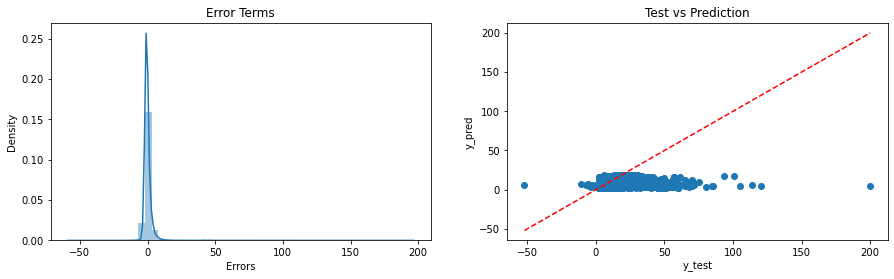

In [21]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

<<<------------------------- Evaluating Ridge Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 0.01204206  0.02299853  0.07469811 -0.37043056  2.79535285  0.06599939
  0.1320065   0.22069881 -0.06375863  0.31634899  0.40009521  0.29126121
  0.03587546  0.04297281  0.02824331  0.19545138  0.53625674  0.62035748
  0.48235245  0.08731832  0.12995267  0.15062433  0.12700495  0.01780948
 -0.05599052  0.09916235  0.13013649  0.08182256  0.06936402  0.0822533
  0.03376945  0.02150019]
The Intercept of the Regresion Model was found to be  8.55061694826981


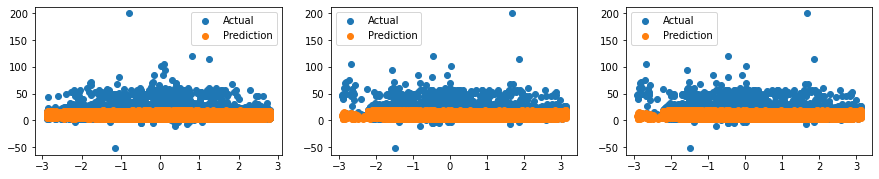



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.4572224949508957
Residual Sum of Squares (RSS) on Training set  ---> 1326512.574670093
Mean Squared Error (MSE) on Training set       ---> 10.160020332639611
Root Mean Squared Error (RMSE) on Training set ---> 3.1874786795584398

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.3294398074715096
Residual Sum of Squares (RSS) on Training set  ---> 557625.5267418809
Mean Squared Error (MSE) on Training set       ---> 17.08359200826816
Root Mean Squared Error (RMSE) on Training set ---> 4.133230214767641

--------------------Residual Plots--------------------


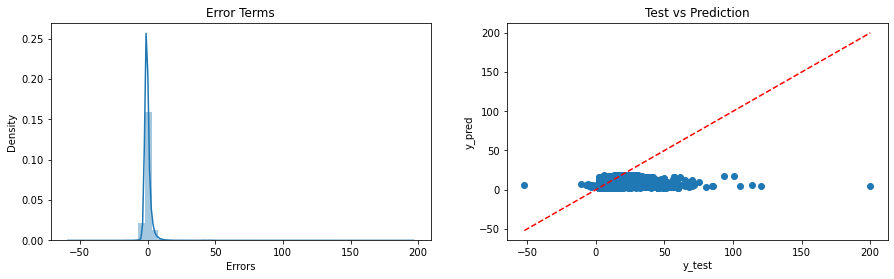

In [22]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

<<<------------------------- Evaluating Lasso Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 0.01204206  0.02299853  0.07469811 -0.37043056  2.79535285  0.06599939
  0.1320065   0.22069881 -0.06375863  0.31634899  0.40009521  0.29126121
  0.03587546  0.04297281  0.02824331  0.19545138  0.53625674  0.62035748
  0.48235245  0.08731832  0.12995267  0.15062433  0.12700495  0.01780948
 -0.05599052  0.09916235  0.13013649  0.08182256  0.06936402  0.0822533
  0.03376945  0.02150019]
The Intercept of the Regresion Model was found to be  8.55061694826981


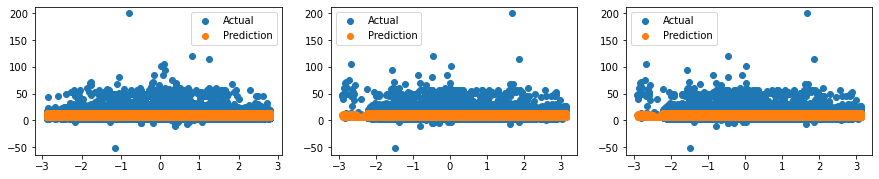



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.3585502318636643
Residual Sum of Squares (RSS) on Training set  ---> 1567661.1052167423
Mean Squared Error (MSE) on Training set       ---> 12.007024288971845
Root Mean Squared Error (RMSE) on Training set ---> 3.4651153355944513

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.2622605216343987
Residual Sum of Squares (RSS) on Training set  ---> 613490.5856410799
Mean Squared Error (MSE) on Training set       ---> 18.795091622226032
Root Mean Squared Error (RMSE) on Training set ---> 4.335330624326827

--------------------Residual Plots--------------------


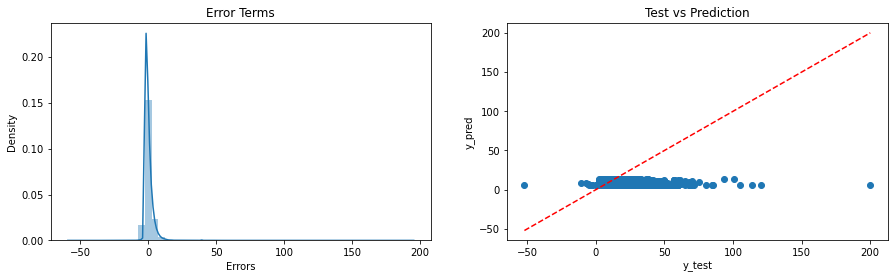

In [23]:
#Creating a Lasso Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

<<<------------------------- Evaluating Elastic-Net Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 0.01204206  0.02299853  0.07469811 -0.37043056  2.79535285  0.06599939
  0.1320065   0.22069881 -0.06375863  0.31634899  0.40009521  0.29126121
  0.03587546  0.04297281  0.02824331  0.19545138  0.53625674  0.62035748
  0.48235245  0.08731832  0.12995267  0.15062433  0.12700495  0.01780948
 -0.05599052  0.09916235  0.13013649  0.08182256  0.06936402  0.0822533
  0.03376945  0.02150019]
The Intercept of the Regresion Model was found to be  8.55061694826981


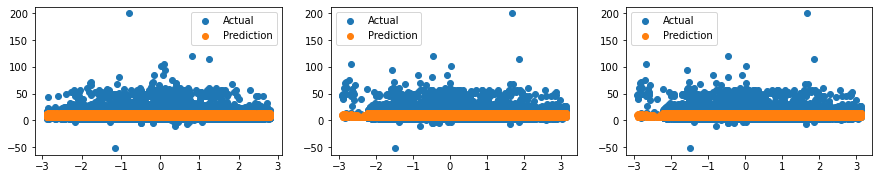



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.32729497804639207
Residual Sum of Squares (RSS) on Training set  ---> 1644046.8928137545
Mean Squared Error (MSE) on Training set       ---> 12.5920780381256
Root Mean Squared Error (RMSE) on Training set ---> 3.5485318144446163

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.23952090035803755
Residual Sum of Squares (RSS) on Training set  ---> 632400.4365887308
Mean Squared Error (MSE) on Training set       ---> 19.37441979684234
Root Mean Squared Error (RMSE) on Training set ---> 4.401638308271403

--------------------Residual Plots--------------------


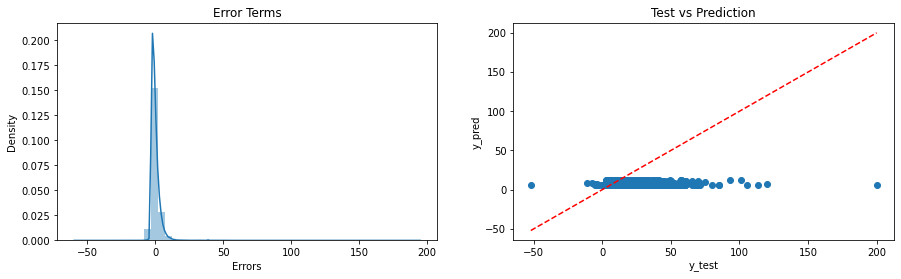

In [24]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

#####

The Dataset was large enough totalling 2M samples & after preprocessing 18.4% of the datasamples were dropped.


Visualising the distribution of data & their relationships, helped us to get some insights on the feature-set.


The features had high multicollinearity, hence in Feature Extraction step, we shortlisted the appropriate features with VIF Technique.


Testing multiple algorithms with default hyperparamters gave us some understanding for various models performance on this specific dataset.